<h1>
    Capstone: Bop It Game
</h1>

Press button to start...
Game over!
Score: 14


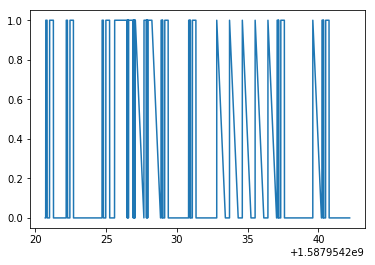

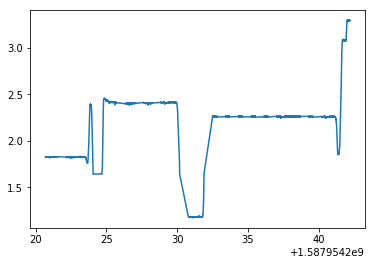

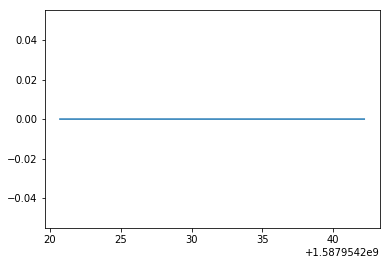

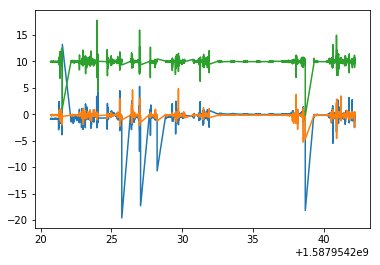

In [15]:
import RPi.GPIO as gp
import numpy as np
import matplotlib.pyplot as plt
import accUtil as acc
import adcUtil as adc
import time
import random
import traceback


#variables

BUTTON_PIN = 23 #pin number for the button
GATE_PIN = 22 #pin number for the mic gate
MIC_CHANNEL = 0 #ADC channel for the mic
POT_CHANNEL = 1 #ADC channel for the potentiometer
POT_THRESHOLD = 1.65 #determines how far to either side the potentiometer has to be turned to register a change
ACCEL_THRESHOLD = 10 #determines how much the accelerometer must be shaken to register a change
LED_PINS = {"clap": 27, "twist": 26, "shake": 25, "press": 24} #dictionary of LED pin numbers, with each LED corresponding to
                                                                #a different sensor


#classes

class Game:
    '''A class that handles all game behavior.'''
    
    def __init__(self, startTime):
        '''Create a new game object.
        Parameters:
            startTime: Timestamp for when the game begins.'''
        
        #class variables
        
        self.MIN_REACTION = 1 #minimum delay between actions
        self.GAME_START = startTime # Time when the game object is created (when the button is pressed)
        self.REACTION_DECREASE = 0.1 #how much to decrease the delay by after every successful action
        self.reactionTime = 3 # Time for the player to do the action, will go down over span of game
        self.points = 0 # Game points the player has earned
        self.lostGame = False #whether or not the player has lost the game
        self.micData = np.array([]) #mic gate data array
        self.potData = np.array([]) #potentiometer data array
        self.accelXData = np.array([]) #accelerometer data for each direction
        self.accelYData = np.array([]) # |
        self.accelZData = np.array([]) # |
        self.buttonData = np.array([]) #button data array
        self.timeData = np.array([]) #timestamps for reference against the other data arrays
      
    def gameIntro(self):
        '''Flash LEDs to let the player know the game is starting.'''
        
        #flash LEDs
        for i in range(3):
            
            for led in LED_PINS:
                gp.output(LED_PINS[led], True)
                
            time.sleep(0.2)
            
            for led in LED_PINS:
                gp.output(LED_PINS[led], False)
                
            time.sleep(0.2)
                
        time.sleep(2) # Give the player 2 seconds to prepare
        
    def runGame(self):
        '''Start and run the game until the player loses.'''
        
        # First, call game Intro to give the user a visual 
        self.gameIntro()
        
        # Run the game until the player loses
        while self.lostGame == False:
            
            action = self.chooseAction() #select an action for the player to take
            gp.output(LED_PINS[action], 1) #turn on appropriate LED
            
            #wait until player takes the action or until they run out of time
            
            actionStart = time.time()
            self.lostGame = True
            
            while time.time() <= actionStart+self.reactionTime:
                
                self.recordData() #get current sensor readings
                
                #turn off led after short delay
                if time.time() >= actionStart+0.3:
                    gp.output(LED_PINS[action], 0)
                
                actionSuccess = False #whether or not player took the indicated action
                
                #check that player took appropriate action
                if action == "clap" and micChange(self):
                    actionSuccess = True
                elif action == "twist" and potChange(self):
                    actionSuccess = True
                elif action == "shake" and accelChange(self):
                    actionSuccess = True
                elif action == "press" and buttonChange(self):
                    actionSuccess = True
                    
                #if action was successfuly taken, award points, lower delay and start next action
                if actionSuccess:
                    
                    self.points += 1
                    self.lostGame = False
                    gp.output(LED_PINS[action], 0)
                    
                    if self.points >= 5 and self.reactionTime > self.MIN_REACTION:
                        self.reactionTime -= self.REACTION_DECREASE
                    
                    for led in LED_PINS:
                        gp.output(LED_PINS[led], 1)
                    time.sleep(0.2)
                    for led in LED_PINS:
                        gp.output(LED_PINS[led], 0)
                        
                    time.sleep(0.4)
                    
                    break
                    
            #end game if player took too long
            if self.lostGame:
                self.gameOver()
                
    def chooseAction(self):
        '''Choose an action for the player to take.
        Returns:
            A string indicating which sensor was selected.'''
        
        choice = random.randint(0,3) # Generate a random number to choose which player Action
        
        if choice == 0:
            return "clap"
        elif choice == 1:
            return "twist"
        elif choice == 2:
            return "shake"
        else:
            return "press"
    
    def gameOver(self):
        '''End the game.'''
        
        print("Game over!\nScore:", self.points)
        self.displayData()
        
        # Flash all LEDs 3 times quickly to indicate the game has ended
        for i in range(3):
            
            for led in LED_PINS:
                gp.output(LED_PINS[led], True)
                
            time.sleep(0.5)
            
            for led in LED_PINS:
                gp.output(LED_PINS[led], False)
                
            time.sleep(0.5)
                
    def recordData(self):
        '''Record one frame of sensor data.'''
        
        accelX, accelY, accelZ = acc.readACC() #get accelerometer data
        
        #log data in respective arrays
        self.micData = np.append(self.micData, gp.input(GATE_PIN))
        self.potData = np.append(self.potData, adc.readADC(POT_CHANNEL))
        self.buttonData = np.append(self.buttonData, gp.input(BUTTON_PIN))
        self.accelXData = np.append(self.accelXData, accelX)
        self.accelYData = np.append(self.accelYData, accelY)
        self.accelZData = np.append(self.accelZData, accelZ)
        self.timeData = np.append(self.timeData, time.time())
        
    def displayData(self):
        '''Display the data recorded throughout one play of the game'''
        #Mic Data
        plt.figure(1)
        plt.plot(self.timeData, self.micData)
        
        #Pot Data
        plt.figure(2)
        plt.plot(self.timeData, self.potData)
        
        #Button Data
        plt.figure(3)
        plt.plot(self.timeData, self.buttonData)
        
        #Accel Data
        plt.figure(4)
        plt.plot(self.timeData, self.accelXData)
        plt.plot(self.timeData, self.accelYData)
        plt.plot(self.timeData, self.accelZData)
    
        
#methods

def setup():
    '''Setup the gpio pins.'''
    
    gp.setmode(gp.BCM)
    
    for pin in LED_PINS:
        gp.setup(LED_PINS[pin], gp.OUT)
        
    gp.setup(BUTTON_PIN, gp.IN, gp.PUD_DOWN)
    gp.setup(GATE_PIN, gp.IN)
    
    #turn off all LEDs in case of weird behavior
    for led in LED_PINS:
        gp.output(LED_PINS[led], 0)
    
def micChange(game):
    '''Detect whether or not the microphone picked up enough noise to change the gate state.
    Parameters:
        game: The game object.
    Returns:
        True if a change was registered, false otherwise.'''
    
    #if there is only 1 sample
    if game.micData.size <= 1:
        return False
    
    #check that most recent sample = signal asserted
    return game.micData[game.micData.size-1] != 0
    
def potChange(game):
    '''Detect whether or not the potentiometer has been turned enough to register a change.
    Parameters:
        game: The game object.
    Returns:
        True if a change was registered, false otherwise.'''
    
    if game.potData.size <= 2:
        return False
    
    #check if potentiometer voltage went from one side of the threshold to another since last measurement
    if game.potData[game.potData.size - 1] >= POT_THRESHOLD:
        return game.potData[game.potData.size - 2] < POT_THRESHOLD
    else:
        return game.potData[game.potData.size - 2] >= POT_THRESHOLD

def buttonChange(game):
    '''Detect whether or not the push button was pressed during the turn.
    Parameters:
        game: The game object.
    Returns:
        True if the button has been pressed, false otherwise.'''
    
    # If there is only 1 sample, no change
    if game.buttonData.size <= 1:
        return False
    
    # check that the button state at some point changed.
    return game.buttonData[game.buttonData.size-1] != game.buttonData[game.buttonData.size-2]
    
def accelChange(game): 
    '''Detect whether or not the accelerometer expeienced signifcant change.
    Parameters:
        game: The game object.
    Returns:
        True if the device has been tilted, false otherwise.'''
    
    #check each axis to see if a significant change is logged
    if game.accelXData[game.accelXData.size-1] >= ACCEL_THRESHOLD or game.accelXData[game.accelXData.size-1] <= -ACCEL_THRESHOLD:
        return True
    elif game.accelYData[game.accelYData.size-1] >= ACCEL_THRESHOLD or game.accelYData[game.accelYData.size-1] <= -ACCEL_THRESHOLD:
        return True
    elif game.accelZData[game.accelZData.size-1] >= 10+ACCEL_THRESHOLD or game.accelZData[game.accelZData.size-1] <= 10-ACCEL_THRESHOLD:
        return True
    
    return False
    
    
#main

try:
    
    setup() #setup gpio
    print("Press button to start...")
    
    #wait for user to press button to start game
    while gp.input(BUTTON_PIN) == False:
        continue
        
    game = Game(time.time()) #create new game object
    game.runGame() #do game loop
    
except: #KeyboardInterrupt
    print("An exception occured.")
    traceback.print_exc() #to print the actual exception, debugging only
finally:
    gp.cleanup()

In [6]:
# Changes

In [ ]:
#Game now fully works. Blinks light corresponding to sensor, briefly blinks all lights when correct action is taken.
#All lights blink slowly on game over and score is printed instead of flashed.

#Switched the LED_PINS back to being a dictionary. It was easier to keep track of which actions lit up each LED.

#Changed the data arrays from being global variables to being part of the game class, I was getting weird errors when they
#were in global scope.

#Added a max and min delay between actions to the game class. max/min delay can be tweaked as well as how much delay decreases
#after each action.

#Moved game loop into Game.runGame()